In [1]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,pr2t,t2pr
from util_fk import *
import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


### Parsing `UR5e`

In [400]:
# env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/test_calibration.xml')

env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


### Get camera informations

In [3]:
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.4,0.0,2.0])
cam_infos

{'cam_distance': 0.0,
 'cam_azimuth': 0.0,
 'cam_elevation': -90.0,
 'cam_lookat': array([1.4, 0. , 2. ])}

### Render a scene

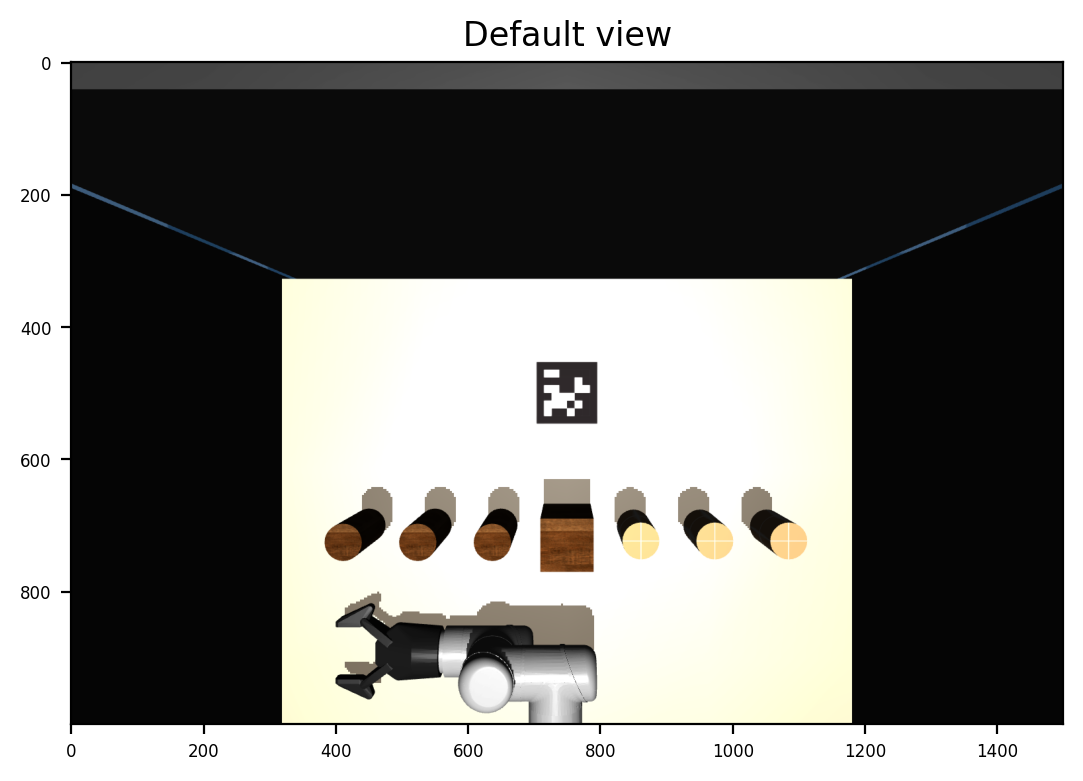

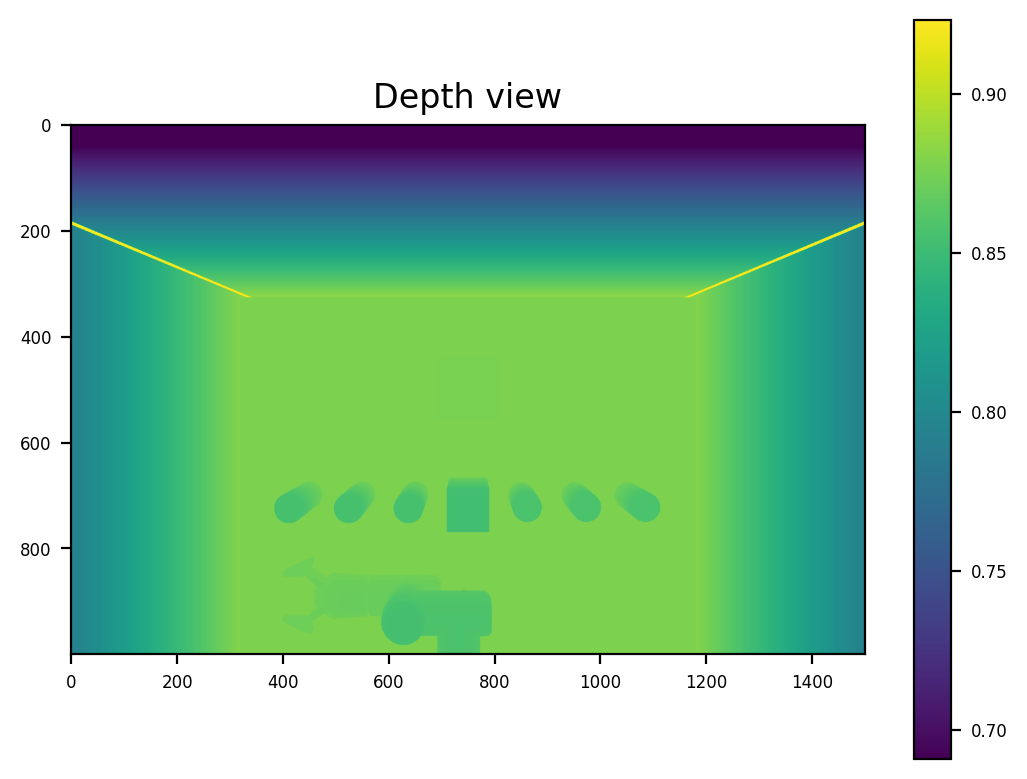

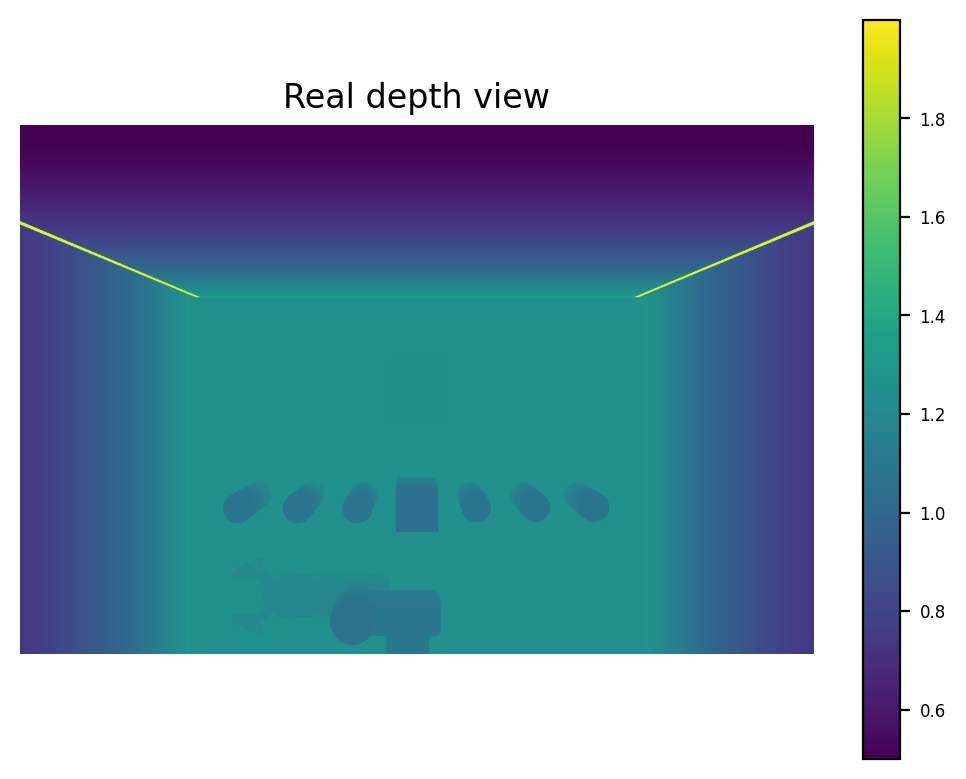

In [389]:
import math

width = 1500
height = 1000
ur_joint_idx = np.array([0, 1, 2, 3, 4, 5, 6], dtype=np.int32)

# env.sim.data.qpos[:8] = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2, 0, 0] 
# torque = [-math.pi/2, -6*math.pi/8, 2*math.pi/3, math.pi/2, math.pi/4, 0, False] 
# env.step(ctrl=torque, ctrl_idxs=ur_joint_idx)

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=True, camera_name="track")
    img_real = env.depth_2_meters(img_depth)

plt.imshow(img); plt.axis('off')
plt.title("Default view")
plt.show()

plt.imshow(img_depth); plt.axis('off')
plt.title("Depth view")
plt.colorbar()
plt.show()

plt.imshow(img_real); plt.axis('off')
plt.title("Real depth view")
plt.colorbar()
plt.show()

In [265]:
import apriltag

detector = apriltag.Detector()
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

# detections, dimg = detector.detect(fram_gray, return_image=True)
results = detector.detect(img_Gray)

cam_matrix, _, _ = env.camera_matrix_and_pose(width=width, height=height, camera_name="main1")
fx = cam_matrix[0][0]
cx = cam_matrix[0][2]
fy = cam_matrix[1][1]
cy = cam_matrix[1][2]

cam_params = [fx, fy, cx, cy]

# Render the detections on the image
if len(results) > 0:
    for r in results:
        pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.12)
        
        poseRotation = pose[:3, :3]
        poseTranslation = pose[:3, 3]


In [266]:
center_x = int(results[0].center.ravel()[0])
center_y = int(results[0].center.ravel()[1])
center_int = np.array((center_x, center_y))

In [267]:
center_int

array([749, 499])

In [268]:
img_depth[center_int[0], center_int[1]]

0.8778947

In [269]:
img_real[center_int[0]][center_int[1]]

1.2600011

### Compute depth imgage(depth) to `3d point (x,y,z)`

In [398]:
def convert_from_uvd(u, v, d):
    """
        pxToMetre: Constant, Means Camera Property
        cx: Center x of Camera
        cy: Center y of Camera
        focalx: Focal length
        focaly: Focal length 
    """
    pxToMetre = 1
    focalx = 1207.10
    focaly =  1207.10
    cx = 750.0
    cy = 500.0
    d *= pxToMetre
    x_over_z = (cx - u) / focalx
    y_over_z = (cy - v) / focaly
    z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z

    return x, y, z

def plot_3d_position(img_real):
    """
        plot 2D images convert to 3D point map
    """
    total_point_real = []
    for i in range(img_real.shape[0]):
        for j in range(img_real.shape[1]): 
            x, y, z = convert_from_uvd(i, j, np.average(img_real[i][j])/(255))
            total_point_real.append([x,y,z])

    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(1, 3, 3,projection='3d')
    ax.scatter([point[0] for point in total_point_real], [point[1] for point in total_point_real], [point[2] for point in total_point_real], s=0.05)
    ax.set_xlabel("X[m]", fontsize=16)
    ax.set_ylabel("Y[m]",fontsize=16)
    ax.set_zlabel("Z[m]", fontsize=16)
    ax.view_init(45,45,0)
    ax.set_zlim(0,1)
    real_dist = [1.4, 0., 2.0] - env.get_p_body(body_name='box_checker')
    plt.title(f"Real-World Distance: {real_dist}", fontsize=20)


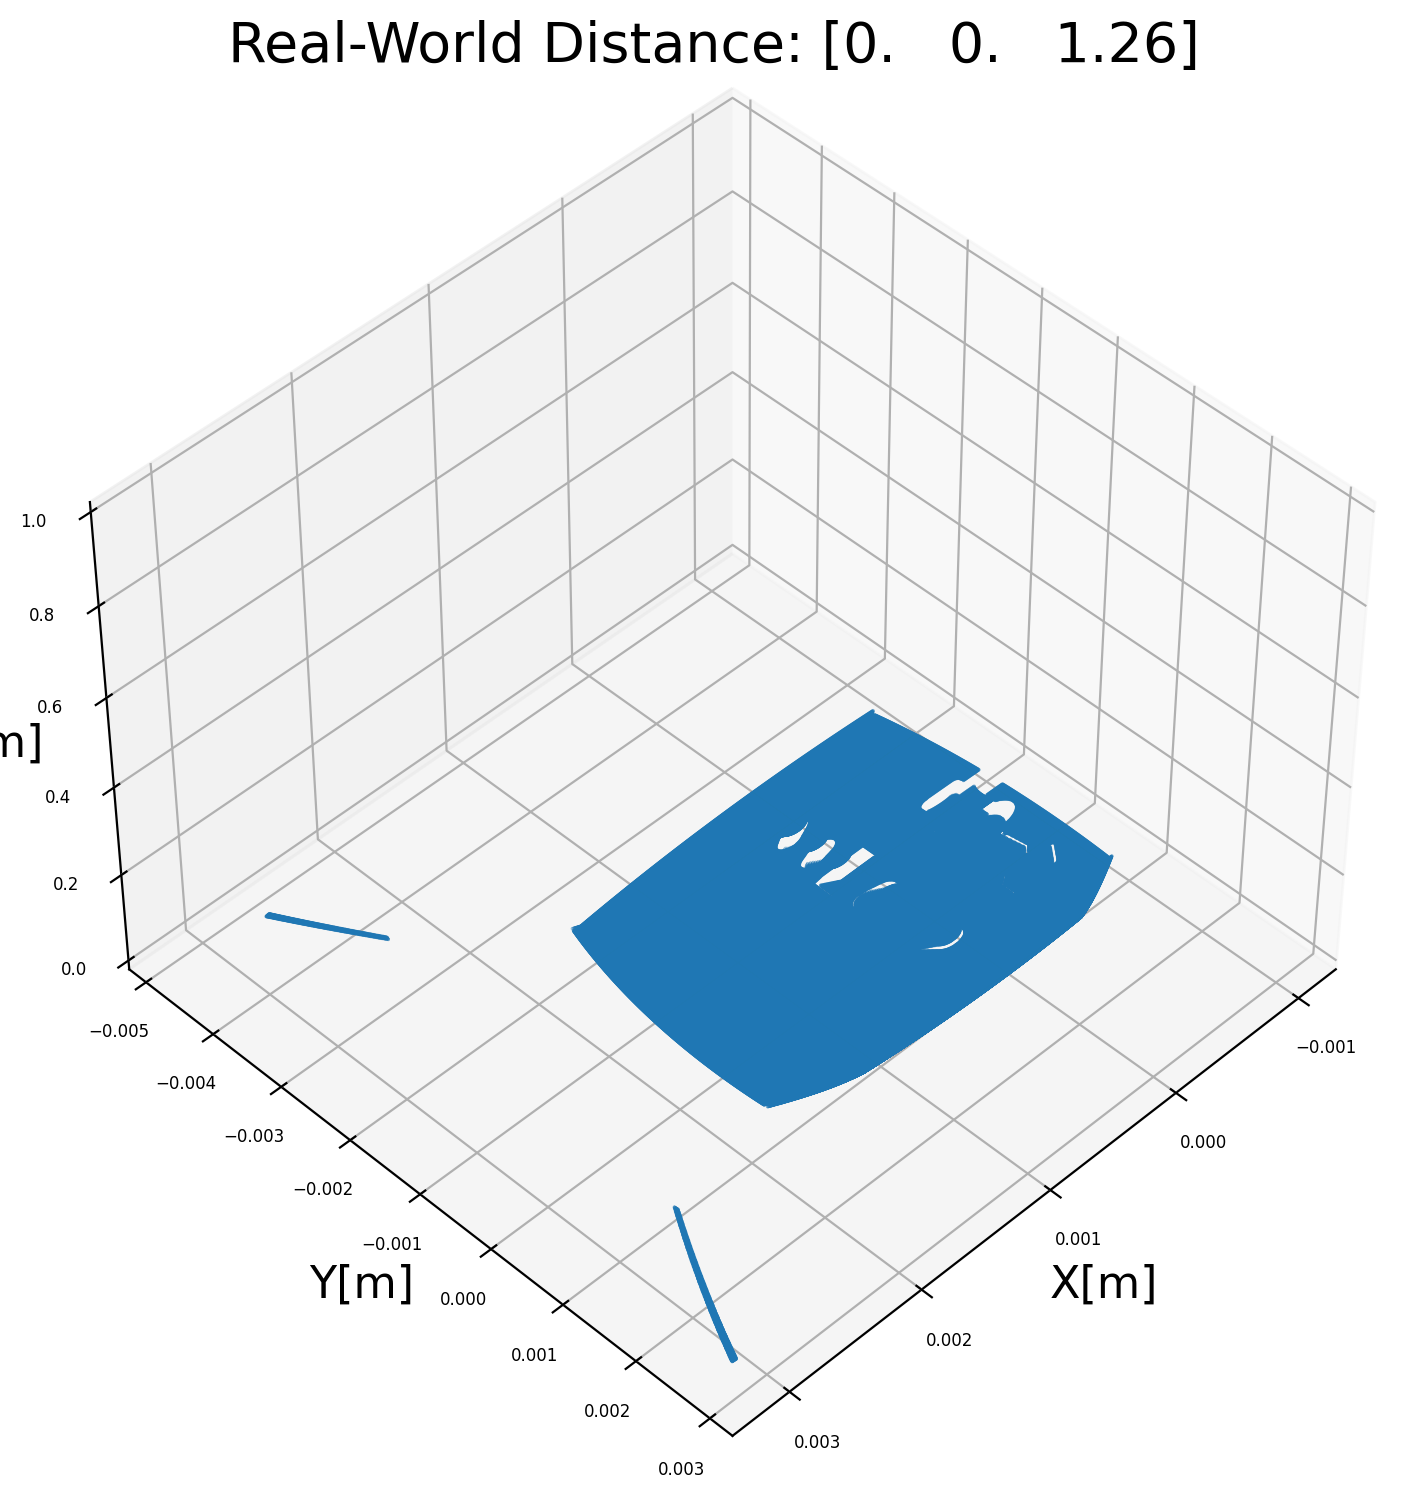

In [399]:
plot_3d_position(img_real)

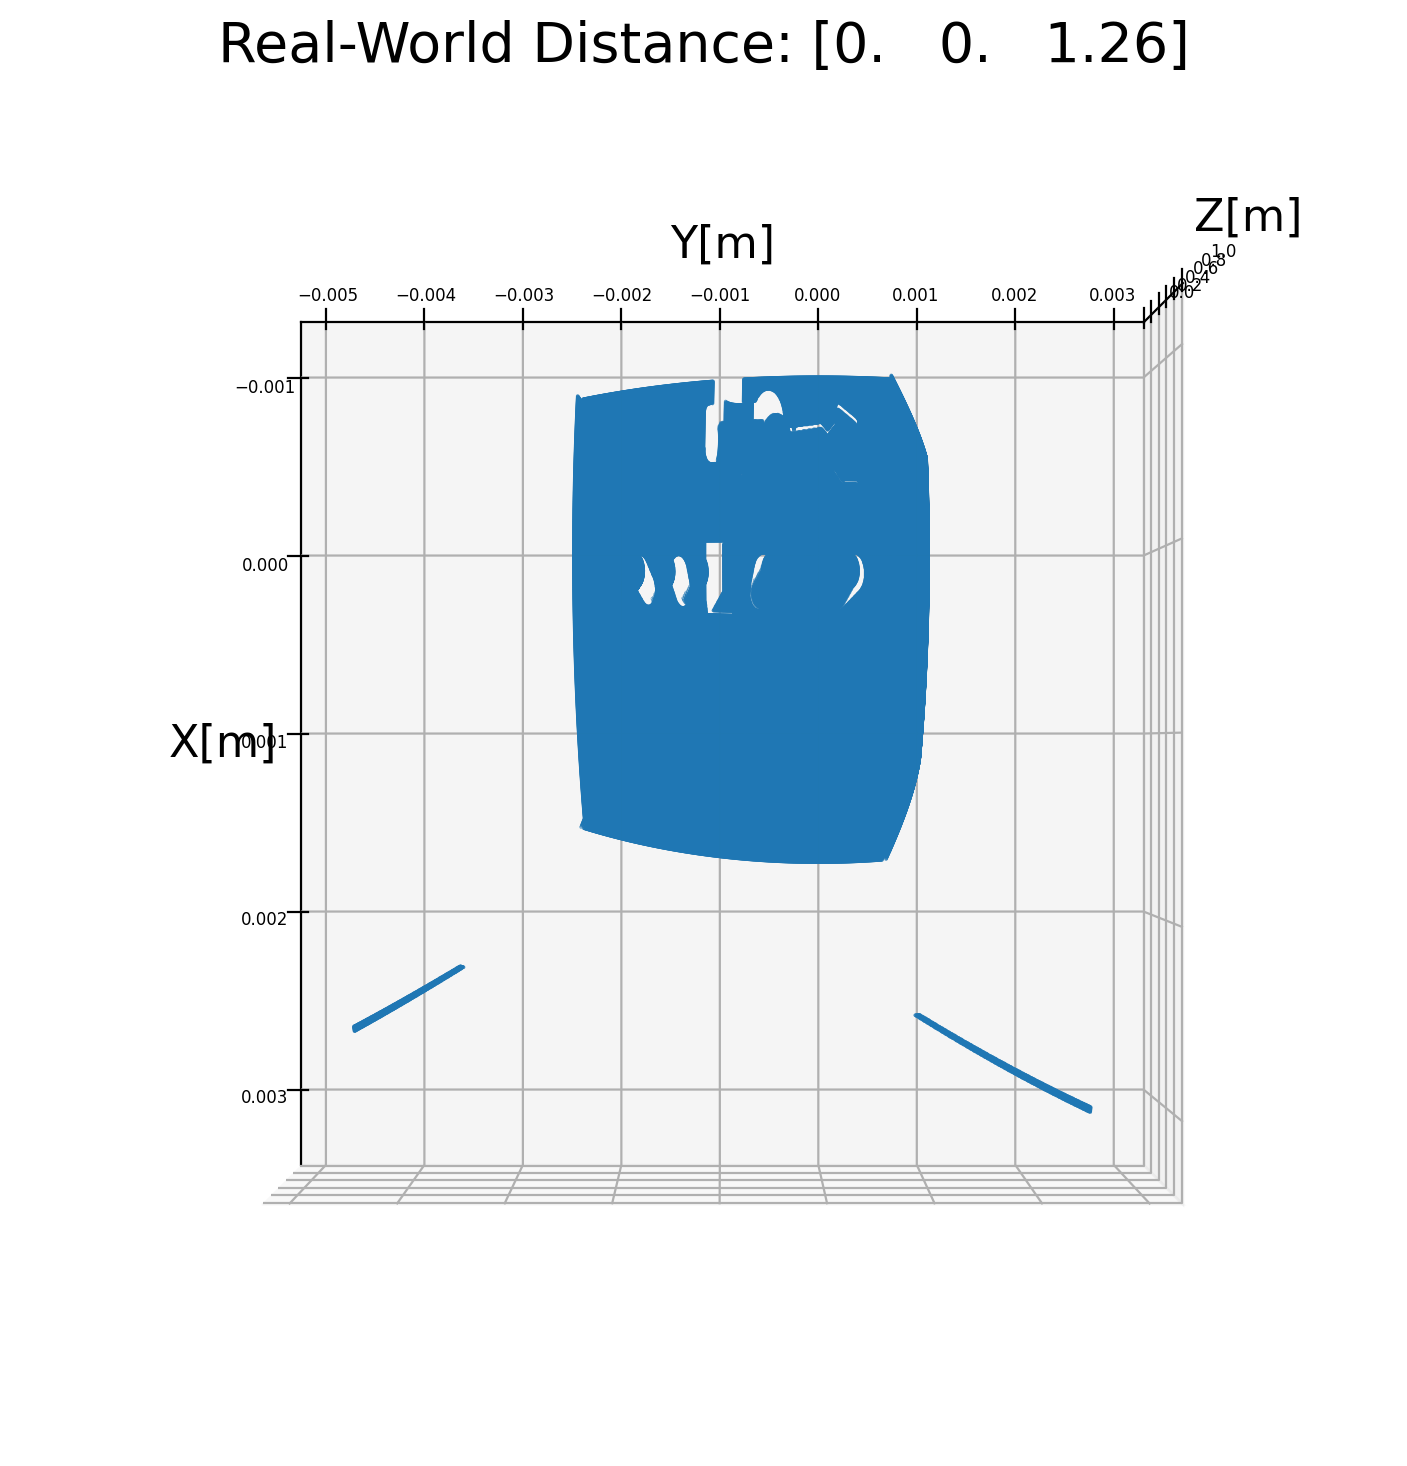

In [397]:
plot_3d_position(img_real)

In [277]:
# 3D position of AprilTag Center-point
convert_from_uvd(center_int[0], center_int[1], img_real[center_int[0], center_int[1]])

(0.0010438242056250652, 0.0010438242056250652, 1.2600001986100162)

In [279]:
cam_id = env.model.camera_name2id("main1")
cam_rot_mat = env.model.cam_mat0[cam_id]
cam_rot_mat = cam_rot_mat.reshape(3, 3)

In [284]:
cam_rot_mat = np.array([[cam_rot_mat[0][0], cam_rot_mat[0][1],  cam_rot_mat[0][2], 0],
                [cam_rot_mat[1][0], cam_rot_mat[1][1],  cam_rot_mat[1][2], 0],
                [cam_rot_mat[2][0], cam_rot_mat[2][1],  cam_rot_mat[2][2], 0],
                [0, 			         0,  0, 0]])
cam_rot_mat

array([[ 0.69,  0.64,  0.33,  0.  ],
       [-0.33,  0.69, -0.64,  0.  ],
       [-0.64,  0.33,  0.69,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [285]:
R_x = cam_rot_mat[:3, :3]@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([1,0,0]))
R_y = cam_rot_mat[:3, :3]@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,1,0]))
R_z = cam_rot_mat[:3, :3]@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))


In [286]:
R_x

array([[ 0.64,  0.33,  0.69],
       [ 0.69, -0.64, -0.33],
       [ 0.33,  0.69, -0.64]])

In [287]:
R_y

array([[-0.33, -0.69,  0.64],
       [ 0.64,  0.33,  0.69],
       [-0.69,  0.64,  0.33]])

In [288]:
R_z

array([[-0.69, -0.64,  0.33],
       [ 0.33, -0.69, -0.64],
       [ 0.64, -0.33,  0.69]])

In [363]:
R_all = R_z @ R_y @ R_x

R_all = np.array([[R_all[0][0], R_all[0][1],  R_all[0][2], 0],
                [R_all[1][0], R_all[1][1],  R_all[1][2], 0],
                [R_all[2][0], R_all[2][1],  R_all[2][2], 0],
                [0, 			         0,  0, 0]])
R_all

array([[-0.19, -0.98,  0.05,  0.  ],
       [-0.83,  0.19,  0.52,  0.  ],
       [-0.52,  0.05, -0.85,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [373]:
cam_rot_mat

array([[ 0.69,  0.64,  0.33,  0.  ],
       [-0.33,  0.69, -0.64,  0.  ],
       [-0.64,  0.33,  0.69,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [365]:
env.get_p_body(body_name='box_checker')

array([1.4 , 0.  , 0.74])

In [366]:
[1.4, 0., 2.0] - env.get_p_body(body_name='box_checker')

array([0.  , 0.  , 1.26])

In [375]:
rot_mat = Rotation_Y(np.deg2rad(90))
trans_mat = Translation(1.4,0,2.0)

ht_mat = HT_matrix(rot_mat, trans_mat)
# ht_mat = HT_matrix(cam_rot_mat, trans_mat)
# ht_mat = HT_matrix(R_all, trans_mat)

print(ht_mat)

point_3d = convert_from_uvd(center_int[0], center_int[1], img_real[center_int[0], center_int[1]])
print(f"3D point of AprilTag about Camera coordinate: \n -> {point_3d}")
# print(env.get_p_body(body_name='box_checker'))
# print([1.4, 0., 2.0])

calc_april = [1.4, 0., 2.0] - env.get_p_body(body_name='box_checker')
print(f"the calculated AprilTag position about Camera is : \n -> {calc_april}")

[[ 6.12e-17  0.00e+00  1.00e+00  1.40e+00]
 [ 0.00e+00  1.00e+00  0.00e+00  0.00e+00]
 [-1.00e+00  0.00e+00  6.12e-17  2.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
3D point of AprilTag about Camera coordinate: 
 -> (0.0010438242056250652, 0.0010438242056250652, 1.2600001986100162)
the calculated AprilTag position about Camera is : 
 -> [0.   0.   1.26]


In [376]:
def c2b(transform_mat, points): # compute to base
    ones = np.ones((len(points),1))
    points = np.concatenate((points,ones),axis=1)
    t_points = points.T
    t_transformed_ponints = np.dot(transform_mat,t_points)
    transformed_ponints = t_transformed_ponints.T
    xyz = transformed_ponints[:,0:3]
    
    return xyz

In [378]:
xyz = c2b(ht_mat, [point_3d])
xyz

array([[2.66e+00, 1.04e-03, 2.00e+00]])

In [371]:
print(point_3d)
print(xyz)

(0.0010438242056250652, 0.0010438242056250652, 1.2600001986100162)
[[1.47 0.65 0.93]]


In [372]:
# world_xyz = c2b(ht_mat, [point_3d])
# world_xyz

### Object position: (1.4, 0.0, 0.74)
### Camera position: (1.4, 0.0, 2.0)
### Obj correspond to cam position: (0.0, 0.0, 1.26)

### display frames as Gif

In [ ]:
from matplotlib import animation
from IPython.display import display, HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_jshtml())

def display_frames_as_gif(frame_list, filename):
    patch = plt.imshow(frame_list[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frame_list[i])
    anim = animation.FuncAnimation(
        plt.gcf(),animate,frames=len(frame_list),interval=20)
    display(display_animation(anim))
    # plt.gcf().savefig("gifs.gif")
    animation.Animation.save(anim, filename, fps=30)
print ("Done.")

: 

In [ ]:
import math
import apriltag

detector = apriltag.Detector()

tick = 0 
frames_list = []

while tick<100:    
    # if tick == 0:
    #     env.sim.data.qpos[:8] = [-math.pi/2, -6*math.pi/8, 2*math.pi/3, math.pi/2, math.pi/4, math.pi, 0, 0] 

    # Get camera info
    if env.tick < 5:
        vi = env.get_cam_infos()    # my code.
        # vi = env.get_viewer_info()
        p_viewer = vi['cam_lookat']
        R_viewer = rpy2r(np.deg2rad([0,-vi['cam_elevation'],vi['cam_azimuth']]))
        T_viewer = pr2t(p_viewer,R_viewer)
        T_marker = T_viewer @ pr2t(np.array([-2,0,0]),np.eye(3)) # minus translate w.r.t. x
        p_marker,R_marker = t2pr(T_marker)

    arm_follow = False
    if arm_follow:
        # ee_position = env.get_p_body("ee_link")
        ee_position = env.get_p_body("robotiq_85_base_link")
        # arbitrary offset about Robot Arm.
        ee_position[2] = ee_position[2] + 0.1
        
        cam_infos = env.set_cam_infos(
                cam_lookat    = ee_position
                )
    print(f"tick:{tick}, cam pose {cam_infos}")

    verbose = False
    if verbose:
        env.print_viewer_info()

    # env.render_scene: render a scene and apply camera pose.
    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")

    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

    # detections, dimg = detector.detect(fram_gray, return_image=True)
    results = detector.detect(img_Gray)
    # print(results)

    cam_matrix, _, _ = env.camera_matrix_and_pose(width=width, height=height, camera_name="main1")
    fx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    fy = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    cam_params = [fx, fy, cx, cy]

    # Render the detections on the image
    if len(results) > 0:
        for r in results:
            pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.06)
            
            poseRotation = pose[:3]
            poseTranslation = pose[3]

    if (tick % 20 == 0):
        plt.imshow(img); plt.axis('off')
        plt.title("Default view")
        plt.show()

    tick += 1
    frames_list.append(img)

# env.terminate_viewer()
display_frames_as_gif(frames_list, "test-calibration-1.gif")

: 

In [ ]:
cam_params
cam_params_2 = [fx, fy, 0, 0]
K = [-fx, fx, width, height]


: 

In [ ]:
pose, e0, e1 = detector.detection_pose(detection=results[0], camera_params=cam_params, tag_size=0.06)
pose_2, e0_, e1_ = detector.detection_pose(detection=results[0], camera_params=cam_params_2, tag_size=0.06)
pose_3, e0_2, e1_2 = detector.detection_pose(detection=results[0], camera_params=K, tag_size=0.06)

: 

In [ ]:
print(pose)
print(pose_2)
print(pose_3)

: 

In [ ]:
plt.matshow(pose)
plt.colorbar()
plt.show()

plt.matshow(pose_2)
plt.colorbar()
plt.show()

plt.matshow(pose_3)
plt.colorbar()
plt.show()

: 

In [ ]:
cam_mat, cam_rot, cam_trans = env.camera_matrix_and_pose(width, height, "main1")

: 

In [ ]:
cam_rot

: 

In [ ]:
cam_trans

: 

### DM-Control: intrinsic matrix

In [ ]:
def matrix(self):
  """Returns the 3x4 camera matrix.
      For a description of the camera matrix see, e.g.,
      https://en.wikipedia.org/wiki/Camera_matrix.
      For a usage example, see the associated test.
  """
  camera_id = self._render_camera.fixedcamid
  if camera_id == -1:
    # If the camera is a 'free' camera, we get its position and orientation
    # from the scene data structure. It is a stereo camera, so we average over
    # the left and right channels. Note: we call `self.update()` in order to
    # ensure that the contents of `scene.camera` are correct.
    self.update()
    pos = np.mean(self.scene.camera.pos, axis=0)
    z = -np.mean(self.scene.camera.forward, axis=0)
    y = np.mean(self.scene.camera.up, axis=0)
    rot = np.vstack((np.cross(y, z), y, z))
    fov = self._physics.model.vis.global_.fovy
  else:
    pos = self._physics.data.cam_xpos[camera_id]
    rot = self._physics.data.cam_xmat[camera_id].reshape(3, 3).T
    fov = self._physics.model.cam_fovy[camera_id]

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos
  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot
  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * self.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]
  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (self.width - 1) / 2.0
  image[1, 2] = (self.height - 1) / 2.0
  return image @ focal @ rotation @ translation

: 